# **Step1. 상품 리뷰 감성 분류**

**미션 : 리뷰마다 긍/부정 감성분석하기**
1) 목표 : 리뷰를 긍, 부정으로 분류하는 모델 생성
사전학습 모델을 파인 튜닝하여 모델 성능 높이기
2) 절차
    * 데이터 전처리
        - 긍/부정 분류를 위한 데이터셋 구성
        - 데이터 불균형 문제 해결하기
    * 사전학습 모델 파인 튜닝 : klue/bert-base 사용 권장
3) 최소 4가지 이상의 실험을 구성하고 수행하고 성능 비교
    * 학습 + 검증 데이터 : 10만 건 중 일부를 샘플링해서 수행.
    * 모델링 : 일반 파인튜닝, LoRA 파인튜닝 적용
    * 하이퍼파라미터 조정


## 1.환경준비

### (1) 라이브러리 설치 및 로딩

In [ ]:
!pip install datasets peft accelerate -q

* 설치 후 세션 다시 시작

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

from peft import get_peft_model, LoraConfig, TaskType

from warnings import filterwarnings
FutureWarning
filterwarnings('ignore')

* 함수 생성

In [ ]:
# 검증셋 평가 함수
def evaluate(val_ds, model, device, tokenizer):
    # 입력 데이터셋 토크나이징 (attention_mask 포함)
    inputs = tokenizer(list(val_ds['text']), return_tensors="pt", padding=True,
                       truncation=True, max_length=256
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}  # 입력 텐서를 동일한 디바이스로 이동

    # 모델을 지정된 디바이스로 이동
    model = model.to(device)

    with torch.no_grad():  # 평가 과정에서 기울기 계산 비활성화
        outputs = model(**inputs)  # attention_mask를 포함해 입력

    # 예측 및 확률 계산
    probabilities = outputs.logits.softmax(dim=1)

    # probabilities가 GPU에 있을 경우에만 CPU로 이동
    if probabilities.is_cuda:
        probabilities = probabilities.cpu().detach().numpy()
    else:
        probabilities = probabilities.detach().numpy()

    pred = np.argmax(probabilities, axis=1)

    # GPU 메모리에서 필요 없는 텐서 제거 및 캐시 정리
    del inputs
    torch.cuda.empty_cache()

    return pred, probabilities

In [ ]:
def predict(text, model, tokenizer):
    # 모델을 CPU로 이동
    model = model.to("cpu")

    # 입력 문장 토크나이징 → CPU 텐서로 생성
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    # 모델 예측 (no_grad로 메모리 절약)
    with torch.no_grad():
        outputs = model(**inputs)

    # 확률 계산
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)

    # 예측 클래스
    pred = torch.argmax(probabilities, dim=-1).item()

    return pred, probabilities


### (2) GPU 설정
* GPU 사용을 위한 설정

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.데이터 준비① : 데이터 구조 만들기
* 아래와 같은 형태로 데이터 셋을 준비합니다.
    * 하나의 리뷰 문장에 하나의 긍/부정 값 지정
    * 리뷰별 label의 평균 값 >= 0.5 ➔ 긍정(1)

* 데이터 불균형을 확인하고 조치합니다.

### (1) 데이터 불러오기
* 제공 받은 'data.csv' 파일을 불러 옵니다.

In [ ]:
# 파일 업로드
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [ ]:
data = pd.read_csv('data.csv')
data

,text,aspect,label
0,유통기한도 넉넉하고 구성도 많아서 선물 하기 좋네요. 만족합니다.,포장,1
1,유통기한도 넉넉하고 구성도 많아서 선물 하기 좋네요. 만족합니다.,품질,1
2,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,보습,1
3,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,포장,0
4,스틱 제형이라 바르기 좋고 보습력도 좋아요. 무엇보다 손에 안 묻히고 바를 수 있어...,기타,1
...,...,...,...
107083,항상 사용하는 제품입니다. 가격 저렴하고 용량도 커서 오래 두고 사용하기 좋아요. ...,밀착,1
107084,상품 잘 받았습니다. 제형이 묽어서 흡수도 빠르지만 흡수 되고 나서 보습이 좋아 촉...,보습,1
107085,상품 잘 받았습니다. 제형이 묽어서 흡수도 빠르지만 흡수 되고 나서 보습이 좋아 촉...,피부,1
107086,상품 잘 받았습니다. 제형이 묽어서 흡수도 빠르지만 흡수 되고 나서 보습이 좋아 촉...,기타,1


### (2) 데이터 구조 만들기

* 다음과 같은 형태로 리뷰별 데이터 구조를 만듭니다.

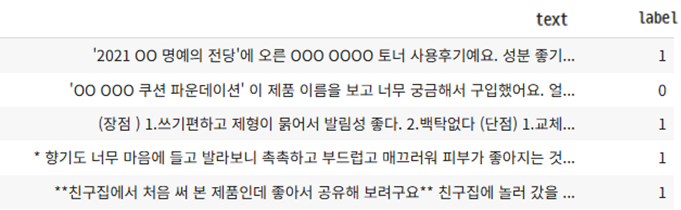

In [ ]:
data.drop_duplicates(subset=['text'], inplace=True)
data.drop(columns = ['aspect'] , inplace = True)
data = data.groupby('text')['label'].mean().reset_index()
data['label'] = (data['label'] >= 0.5).astype(int)
data = data.sample(7000 , random_state = 42)
data.head()

,text,label
9134,동생에게 선물했어요. 향도 은은하게 오래 지속된다고 너무 좋아하네요. OOO라서 그...,1
13214,밤에 바르고 아침에 일어나면 피부 진정되어 있습니다 순해서 가족모두 사용하는데 여름...,1
11779,미스트 쿠션이라하여 선택하였는데 잘 모르겠네요. 지속성 부족합니다. 다른 쿠션보다 ...,0
26845,이동하기 편한 사이즈라 수시로 피부 관리하라고 친구가 추천해서 구매했어요. 가격대비...,0
37301,항상 애용하는 제품입니다. 썬크림으로 바르기 편하고 휴대히기 편해서 좋습니다. 잘 ...,1


### (3) 데이터 불균형 해결하기

* label의 분포 확인하기

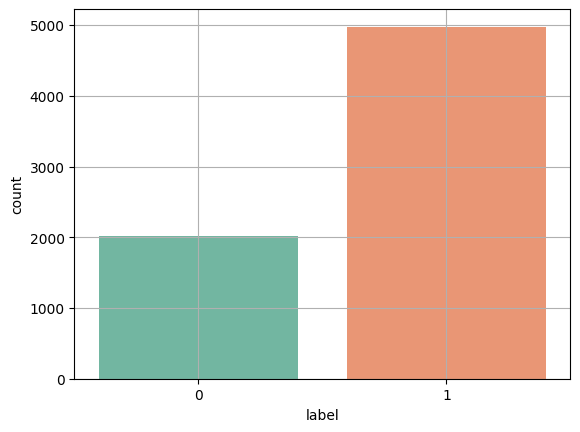

In [ ]:
sns.countplot(x='label', data = data, palette='Set2')
plt.grid()
plt.show()

* label이 0과 1인 인 경우 각각 샘플링 2000건씩
    * 더 많이 할 수도 있지만 학습 시간을 고려


In [ ]:
data_0 = data[data['label'] == 0].sample(n=2000, random_state=42)
data_1 = data[data['label'] == 1].sample(n=2000, random_state=42)

data_balanced = pd.concat([data_0, data_1]).sample(frac=1, random_state=42).reset_index(drop=True)
# frac = 1 은 데이터 전체를 섞는다는 것 .

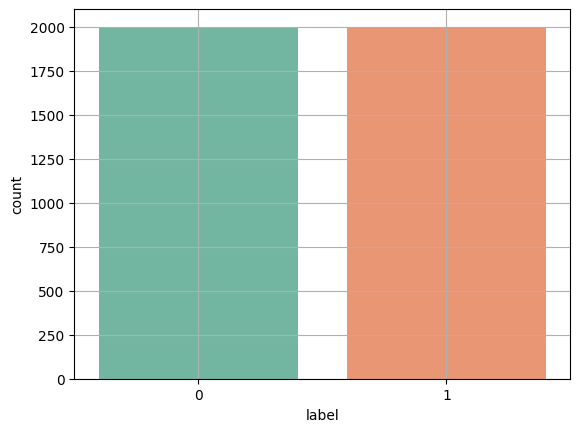

In [ ]:
# 데이터 분포 다시 확인
sns.countplot(x='label', data = data_balanced, palette='Set2')
plt.grid()
plt.show()

## 3.데이터 준비② : 데이터 전처리

### (1) Dataset 만들기 : train, val
* train_test_split 함수 이용

In [ ]:
train , val = train_test_split(data_balanced , test_size=0.2 , random_state=42 , stratify = data_balanced['label'])

In [ ]:
train['label'].value_counts() , val['label'].value_counts()

(label
 1    1600
 0    1600
 Name: count, dtype: int64,
 label
 1    400
 0    400
 Name: count, dtype: int64)

* 텐서 데이터셋 만들기

In [ ]:
# df로 부터 텐서 데이터셋 만들기
train_ts = Dataset.from_pandas(train)
val_ts = Dataset.from_pandas(val)

In [ ]:
train_ts[:3]

{'text': ['가격 저렴하고 좋은데 쓰려고 보니 용기가 튜브식이 아니라 조금 실망했습니다. 튜브 용기가 아니라서 필요한 양만큼 사용하기가 안 좋네요.',
  '효과가 좋은진 모르겠네요..흡수도 그닥 안되고 그래도 바르연 쫀득쫀득하구요.. 더 발라봐야죠',
  '펌프형이 아니네요 ㅜㅜ 따라쓰는건줄알았음 안하는건데 사용하기 불편해요 유통기간도 넉넉하지 않아요'],
 'label': [1, 0, 0],
 '__index_level_0__': [3461, 682, 927]}

### (2) 토크나이징
* 모델 : "klue/bert-base"

In [ ]:
# 모델과 토크나이저 불러오기
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# 토큰화 함수 생성 및 작업
def preprocess_function(data_balanced):
    return tokenizer(data_balanced['text'], truncation=True, padding=True)

train_ts = train_ts.map(preprocess_function, batched=True)
val_ts = val_ts.map(preprocess_function, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [ ]:
train_ts[0]

{'text': '가격 저렴하고 좋은데 쓰려고 보니 용기가 튜브식이 아니라 조금 실망했습니다. 튜브 용기가 아니라서 필요한 양만큼 사용하기가 안 좋네요.',
 'label': 1,
 '__index_level_0__': 3461,
 'input_ids': [2,
  3852,
  6206,
  19521,
  1560,
  2073,
  2147,
  1363,
  10554,
  1160,
  2209,
  6153,
  2116,
  18566,
  2096,
  2052,
  3614,
  2181,
  4027,
  7334,
  2371,
  2219,
  3606,
  18,
  18566,
  6153,
  2116,
  3614,
  2181,
  2112,
  3677,
  2470,
  1402,
  22883,
  3704,
  31302,
  2116,
  1378,
  1560,
  2203,
  2182,
  18,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

## 4.Fine-Tuning ①
* 일반 파인 튜닝 수행

### (1) 사전학습 모델 준비

In [ ]:
# 모델 로드
# 모델 설정 (다중 분류를 위해 num_labels 지정)
n = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels = n).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) 학습 설정

In [ ]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-5,               # 작은 학습률
    per_device_train_batch_size = 32,   # 학습 배치 사이즈
    per_device_eval_batch_size = 32,
    num_train_epochs = 5,               # 에폭 수
    weight_decay = 0.02,                # weight decay
    load_best_model_at_end = True,      # earlystopping 사용하기 위해 필요
    logging_dir ='./logs',
    logging_steps = 10,
    report_to="tensorboard"
)

In [ ]:
# Trainer 설정
trainer = Trainer(
    model=model,                         # 학습할 모델
    args=training_args,                  # TrainingArguments
    train_dataset = train_ts,
    eval_dataset = val_ts,
    tokenizer = tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], # 조기 종료
)

### (3) 학습

In [ ]:
# 모델 학습(6~10분 소요)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.302800,0.268464
2,0.205200,0.240617
3,0.115500,0.305149
4,0.074200,0.367777
5,0.011100,0.398204


TrainOutput(global_step=500, training_loss=0.16049661771953105, metrics={'train_runtime': 1656.863, 'train_samples_per_second': 9.657, 'train_steps_per_second': 0.302, 'total_flos': 4209776885760000.0, 'train_loss': 0.16049661771953105, 'epoch': 5.0})

In [ ]:
# 모델 평가
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.24061685800552368, 'eval_runtime': 13.8814, 'eval_samples_per_second': 57.631, 'eval_steps_per_second': 1.801, 'epoch': 5.0}


### (4) 모델 검증평가

In [ ]:
pred, prob = evaluate(val_ts, model, device, tokenizer)

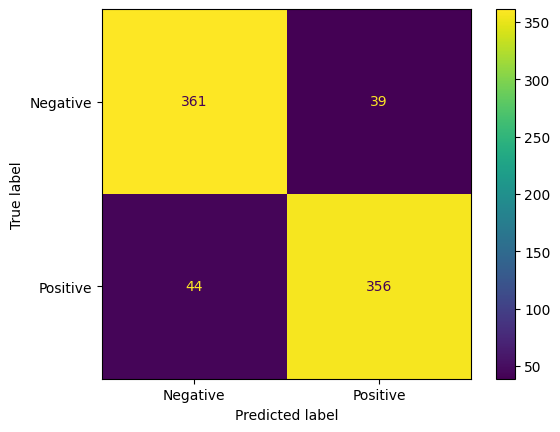

              precision    recall  f1-score   support

    Negative       0.89      0.90      0.90       400
    Positive       0.90      0.89      0.90       400

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(val_ts['label'], pred), display_labels = ['Negative' , 'Positive'])
disp.plot()
plt.show()

print(classification_report(val_ts['label'], pred, target_names = ['Negative' , 'Positive']))

## 5.Fine-Tuning②
* LoRA(Low-Rank Adaptation)

### (1) 사전학습 모델 준비
* 위에서 적용한 내용

In [ ]:
# 모델 로드
model_name = "klue/bert-base"
n = 2
tokenizer = AutoTokenizer.from_pretrained(model_name)

base_model = AutoModelForSequenceClassification.from_pretrained(model_name , num_labels = n)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### (2) LoRA 구성

In [ ]:
# LoRA 구성 정의
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # 시퀀스 분류
    r=8,                         # 랭크 값 (작을수록 파라미터 적음)
    lora_alpha=32,               # 너무 작으면 학습 효과 약하고, 너무 크면 발산 위험
    lora_dropout=0.1,
    target_modules=["query", "value"],
    bias="none"                 # bias는 학습하지 않음
)

# LoRA 적용 (일부 레이어만 학습)
model = get_peft_model(base_model, lora_config)

### (3) 학습

In [ ]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 2e-4,               # LoRA는 조금 큰 학습률
    per_device_train_batch_size = 32,   # 학습 배치 사이즈
    per_device_eval_batch_size = 32,
    num_train_epochs = 3,               # 에폭 수
    weight_decay = 0.02,                # weight decay
    load_best_model_at_end = True,      # earlystopping 사용하기 위해 필요
    logging_dir ='./logs',
    logging_steps = 10,
    report_to="tensorboard"
)

# Trainer 설정 (compute_metrics, callbacks 등 필요 시 추가)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ts,
    eval_dataset=val_ts,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
# 학습 시작
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.382200,0.344281
2,0.290400,0.297157
3,0.235200,0.279270


TrainOutput(global_step=300, training_loss=0.35007964769999184, metrics={'train_runtime': 744.1932, 'train_samples_per_second': 12.9, 'train_steps_per_second': 0.403, 'total_flos': 2534608797696000.0, 'train_loss': 0.35007964769999184, 'epoch': 3.0})

### (4) 모델 검증평가

In [ ]:
pred, prob = evaluate(val_ts, model, device, tokenizer)

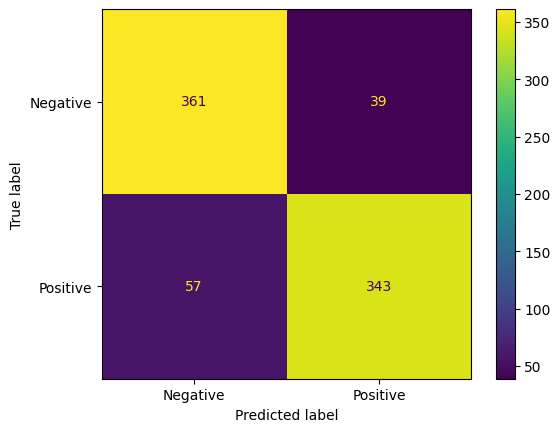

              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88       400
    Positive       0.90      0.86      0.88       400

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(val_ts['label'], pred), display_labels = ['Negative' , 'Positive'])
disp.plot()
plt.show()

print(classification_report(val_ts['label'], pred, target_names = ['Negative' , 'Positive']))

In [ ]:
# 오분류 문장들 추출하여 알아본 것
val_df = val_ts.to_pandas()

# 실제/예측/확률 배열 준비
y_true = val_df['label'].to_numpy()
y_pred = np.array(pred)
y_prob = np.array(prob)[:, 1]  # 긍정 확률

# 오분류
wrong_sentence = y_true != y_pred

# 오분류 데이터만 추출
wrong_df = val_df.loc[wrong_sentence, ['text', 'label']].copy()
wrong_df['pred'] = y_pred[wrong_sentence]
wrong_df['prob_pos'] = y_prob[wrong_sentence]

# 보기 좋게 정렬 (모델이 높은확률로 틀린 문장부터)
wrong_df = wrong_df.sort_values('prob_pos', ascending=False).reset_index(drop=True)

# 상위 10개 확인
pd.set_option('display.max_colwidth', None)
wrong_df.head(10)

# label : 실제값 , pred : 예측값 , prob_pos : 긍정확률

,text,label,pred,prob_pos
0,점성이 로션보다 더 묽어요 바르고 난 느낌이 가벼워서 매일 사용하기는 좋아요,0,1,0.984469
1,선크림을 바르긴 발라야겠는데 문제는 선크림 후 화장이 너무 떠서 화장할 때 난감한 경험 다들 있지 않으신가요? 로션처럼 촉촉하게 잘 발리고 안 뜨는 선크림 가져와봤어요 일단 톤업기능이 사알짝 들어가 있어서 적당히 피부톤을 1차로 보정해주니까 이후 파데를 꼭 발라야 하나 싶을 때도 있어요 ㅎㅎ 지속성도 적당해서 6시간 지나서 거울 봤을 때 다크닝은 거의 없더라구요 넘 좋아요 바를 때도 로션과 보통 선크림의 중간 정도의 제형이라 부담없이 잘 발려서 좋아요 이렇게 발려야 다음 파데 단계에서 안 밀리더라구요 가격이 조금 부담되지면 넘 만족해서 앞으로도 쭉 쓸 것 같아요,0,1,0.979806
2,하나도 안 땡기고 촉촉하고 좋습니다. 제형이 되직해서 두껍게 바르면 밀리네요. 일반 피부는 자기전 나이트 크림으로 아주 좋습니다.,0,1,0.951813
3,눈가와 팔자주름이 많이 신경썼는데.. 간단하면서 언제 어디서나 편하게 보습에 도움이 될까 싶어 구매했어요 그전부터 광고보며 호기심반 궁금반으로 고민했는데 사용해보니 좋네요 문지르며 바르면 많이 번들거리지만 톡톡 두들기면 번들거림이 덜하더라구요 전 기대만큼 만족하고 효과좋으면 방송때 꼭 구입할려구요 방송언제 하는지 아직 예정없다시기에 기다릴게요~~얼른 방송해주세요~b,0,1,0.948866
4,겨울에 피부가 건조해서 사용했는데 촉촉하지는 않네요. 그래도 향이 좋아서 이것만 사용하게 됩니다. 배송도 빨랐어요.,0,1,0.909568
5,촉촉하고 두껍게 발리지 않아서 좋습니다. 조금 묻어나지만 다른 팩트나 BB크림보다는 덜 묻어납니다. 아침에 바르고 저녁에 세수해 보면 그때도 얼굴이 촉촉해요. 재구매 의향 있습니다.,0,1,0.890827
6,가희멀티밤을 써보고 너무 좋아서 기미관리멀티밤도 믿고 구매했어요..보습은 핑크멀티밤이 더좋은거 같은데 기미관리는 좀더 사용해봐야될거 같아요.,0,1,0.880495
7,적어도 제 또래에서는 에센스 중에 제일 유명한 에센스가 이거 아닐까 싶네요. 20대 때 이게 그렇게 좋다고들 해서 큰마음 먹고 사서 발라 봤지만 그땐 피부도 어려서 철이 없었는지 이게 뭐가 좋다는 거냐며 쓰다 말았던 적이 있었죠ㅎㅎ 이제 나이 먹어서 피부가 철이 들었나 봐요. 비싼 거 발라 주니까 좋은 걸 아네요^^; 하루만 발라 보고서도 효과에 감탄이 절로 나오더라고요. 효과가 진짜 좋습니다. 바르자마자 수분감이 꽉 차오르고 피부결이 부드러워져요. 자극도 없고 영양감 이 무슨 일이랍니까 대박 ㅠㅠ 피부가 젊어서 자신감 가득할 때 말고 저처럼 피부가 겸손해졌을 때 써 보세요. 진짜 좋아요...,0,1,0.837803
8,가히는 워낙 유명하니까 ~~~ 사용하기 간편하고 주름이 금새 개선되지는 않지만 촉촉한 상태로 오래유지시켜주니 당김이 덜하고 잔주름에 좋은것같아요 효과는 더 써봐야겠지만 기대됩니다,0,1,0.819325
9,지인꺼 써보고 너무 좋아서 자매둘이서 나눠쓸려고 구매했어요 좀더밝은 색상의 제품이 있엇으면 좋겠고 촉촉은 평범하고 건조하지는 않아요 제일 좋았던 점은 광채랑 피부결이 너무 좋아서 구매하거됐어요 비비는 써보니 느낌이 조금 건조한듯 싶고 커버력은 더 좋은거 같아요 딜이 계속 있었으면 좋겠어요,0,1,0.802227


In [ ]:
0.88 / 0.90

0.9777777777777777